# Imports

In [138]:
!pip install sweetviz
import pandas as pd
import numpy as np
import sweetviz as sv
import matplotlib.pyplot as plt

Defaulting to user installation because normal site-packages is not writeable


# What has already been done
To begin the research, we tried to use classification, because it seemed like a more interesting task, but it was obivous that classes are not separable. The picture of the data TSNE is attached (showing classification lines of code seems unnecessary). The marks were separated into classes: {fail, sufficient, satisfactory, good, excellent}, based on the official grading system of Portugal. We tested several models (Logit, Random Forest), which resulted in low quality. This dataset has a public notebook with classification, reaching a high score, but it seems to have *target leakage* problem, because it includes average grades in features for predicting final grade. 

<center><img src="separability.png"></center>

Since good quality on classification problem is hardly feasible, We decided to stick with the original dataset task of regressing the marks based on given regressors.

Public notebooks on regression seem to mainly focus on OLS regression and Tree Regressors, but do not really offer:

* Econometric testing (P-value, VIFs)

* Economic Interpretation

* CV and extended model testing (mostly focuses on several models)

So it seems, that there is still plenty of work that can be done on this data. 

## Task

**Build an optimal regression model, using G3 as a target variable and other variables (excluding G1, G2) as regressors** 

# Data overview

First, we need to take a look at the data: general information, missings, description

In [139]:
data = pd.read_csv("student-por.csv")
data.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13


In [140]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      649 non-null    object
 1   sex         649 non-null    object
 2   age         649 non-null    int64 
 3   address     649 non-null    object
 4   famsize     649 non-null    object
 5   Pstatus     649 non-null    object
 6   Medu        649 non-null    int64 
 7   Fedu        649 non-null    int64 
 8   Mjob        649 non-null    object
 9   Fjob        649 non-null    object
 10  reason      649 non-null    object
 11  guardian    649 non-null    object
 12  traveltime  649 non-null    int64 
 13  studytime   649 non-null    int64 
 14  failures    649 non-null    int64 
 15  schoolsup   649 non-null    object
 16  famsup      649 non-null    object
 17  paid        649 non-null    object
 18  activities  649 non-null    object
 19  nursery     649 non-null    object
 20  higher    

In [141]:
data.isna().any()

school        False
sex           False
age           False
address       False
famsize       False
Pstatus       False
Medu          False
Fedu          False
Mjob          False
Fjob          False
reason        False
guardian      False
traveltime    False
studytime     False
failures      False
schoolsup     False
famsup        False
paid          False
activities    False
nursery       False
higher        False
internet      False
romantic      False
famrel        False
freetime      False
goout         False
Dalc          False
Walc          False
health        False
absences      False
G1            False
G2            False
G3            False
dtype: bool

**It can be seen that data does not have any missings!** 

In [142]:
data.describe()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
count,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000
mean,16.744222,2.514638,2.306626,1.568567,1.930663,0.221880,3.930663,3.180277,3.184900,1.502311,2.280431,3.536210,3.659476,11.399076,11.570108,11.906009
std,1.218138,1.134552,1.099931,0.748660,0.829510,0.593235,0.955717,1.051093,1.175766,0.924834,1.284380,1.446259,4.640759,2.745265,2.913639,3.230656
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,16.000000,2.000000,1.000000,1.000000,1.000000,0.000000,4.000000,3.000000,2.000000,1.000000,1.000000,2.000000,0.000000,10.000000,10.000000,10.000000
50%,17.000000,2.000000,2.000000,1.000000,2.000000,0.000000,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000,2.000000,11.000000,11.000000,12.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,6.000000,13.000000,13.000000,14.000000
max,22.000000,4.000000,4.000000,4.000000,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,32.000000,19.000000,19.000000,19.000000


* We can see, that there are some weird values that have int quantiles: *We have a lot of ordinal values*. Data has some variables that are sourced from the survey, so  some variables rank students on a scale (mainly, 1 to 5), ranging from "very low" to "very high" or, for example, in case of famrel (family relationship) it goes from 1 (very bad) to 5 (excellent). Also, age can be seen as one, since it does not have intermediate values, only ints. The detailed description of variables can be seen below, but for now on we need to take into account that we have such variables. Most internet articles recommend to treat these variables as default numeric variables. The better way of handling them **needs to be derived in the process of comparing models**. Dummy variables can be more easy to interpret, but detrimental to quality of model

* There are a lot of categorical variables, since describe only shows numeric variables. Most of them contain of Yes/No answers to questions, but there are some non-binary categoricals. For example, MJob and Fjob, which characterize parents' jobs

* There are one numeric variable: absences.

**So the data mainly focuses on qualitative variables, rather than on quantitative**. This can be a challenging characteristic in the model building part


### Variable list

* school - student's school (binary: 'GP' - Gabriel Pereira or 'MS' - Mousinho da Silveira)
* sex - student's sex (binary: 'F' - female or 'M' - male)
* age - student's age (numeric: from 15 to 22)
* address - student's home address type (binary: 'U' - urban or 'R' - rural)
* famsize - family size (binary: 'LE3' - less or equal to 3 or 'GT3' - greater than 3)
* Pstatus - parent's cohabitation status (binary: 'T' - living together or 'A' - apart)
* Medu - mother's education (numeric: 0 - none, 1 - primary education (4th grade), 2 - 5th to 9th grade, 3 - secondary education or 4 - higher education)
* Fedu - father's education (numeric: 0 - none, 1 - primary education (4th grade), 2 - 5th to 9th grade, 3 - secondary education or 4 - higher education)
* Mjob - mother's job (nominal: 'teacher', 'health' care related, civil 'services' (e.g. administrative or police), 'at_home' or 'other')
* Fjob - father's job (nominal: 'teacher', 'health' care related, civil 'services' (e.g. administrative or police), 'at_home' or 'other')
* reason - reason to choose this school (nominal: close to 'home', school 'reputation', 'course' preference or 'other')
* guardian - student's guardian (nominal: 'mother', 'father' or 'other')
* traveltime - home to school travel time (numeric: 1 - <15 min., 2 - 15 to 30 min., 3 - 30 min. to 1 hour, or 4 - >1 hour)
* studytime - weekly study time (numeric: 1 - <2 hours, 2 - 2 to 5 hours, 3 - 5 to 10 hours, or 4 - >10 hours)
* failures - number of past class failures (numeric: n if 1<=n<3, else 4)
* schoolsup - extra educational support (binary: yes or no)
* famsup - family educational support (binary: yes or no)
* paid - extra paid classes within the course subject (Math or Portuguese) (binary: yes or no)
* activities - extra-curricular activities (binary: yes or no)
* nursery - attended nursery school (binary: yes or no)
* higher - wants to take higher education (binary: yes or no)
* internet - Internet access at home (binary: yes or no)
* romantic - with a romantic relationship (binary: yes or no)
* famrel - quality of family relationships (numeric: from 1 - very bad to 5 - excellent)
* freetime - free time after school (numeric: from 1 - very low to 5 - very high)
* goout - going out with friends (numeric: from 1 - very low to 5 - very high)
* Dalc - workday alcohol consumption (numeric: from 1 - very low to 5 - very high)¶
* Walc - weekend alcohol consumption (numeric: from 1 - very low to 5 - very high)
* health - current health status (numeric: from 1 - very bad to 5 - very good)
* absences - number of school absences (numeric: from 0 to 93)

### About target

Now we need to talk mode about target variable. Data has G1, G2, G3, which are students' grades in portugeese in 1-st year period, 2-nd year period and a final grade. 
The more challenging and economically logical approach here is to drop G1 and G2 and to predict final grades

In [143]:
data.drop(columns = ["G1", "G2"], inplace = True)

## Ploting the data

### Histograms

Now we need to plot all the data in order to determine features distribution

In [144]:
report = sv.analyze(data)

Done! Use 'show' commands to display/save.   |██████████| [100%]   00:02 -> (00:00 left)


In [145]:
# this thing will open a browser tab, please don't be scared
report.show_html()

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


We get some additional information from histograms:

* Unbalanced features

* A LOT of categorical features

* Data have some ordinal categorical features ("age", "Medu", "Fedu", "travel_time", "study_time", "famrel", "freetime", "goout", "Dacl", "Walc", "health")

* Some values are not encoded

Now let's look seperately at our target value

In [146]:
import plotly.express as px
G3 = data.G3
fig = px.histogram(G3, opacity = 0.8)
fig.update_traces(marker=dict(color='#9A99D6'))
fig.update_layout(title='G3 distribution', title_x = 0.5)
fig.show()


In [147]:
from scipy.stats import norm
import plotly.graph_objects as go
  
# Generate some data for this 
# demonstration.
dat = data['G3']
  
# Fit a normal distribution to
# the data:
# mean and standard deviation
mu, std = norm.fit(dat) 
x = np.linspace(0, 20, 100)
p = norm.pdf(x, mu, std)
fig = px.histogram(G3, opacity = 0.8, histnorm="probability")
fig.update_traces(marker=dict(color='#9A99D6'))

fig.add_trace(go.Scatter(x = x, y = p, mode = "lines", opacity = 0.6, line = dict(color = "#D44D35")))

fig.update_layout(title='Histogram of G3', title_x = 0.5, showlegend = False)
fig.show()

Based on this graphs it seems like the target has some outliers at G3 = 0. To support this claim we will need additional statistical testing. Other than that the data does seem to be of a normal distribution with some peak in G3 = 10, which breaks out of normal distribution. We need to convey additional tests to determine the normality of G3

### Box-plots

In [148]:
categorical_data = data.select_dtypes(include='object')
categorical_data.shape

(649, 17)

In [149]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
fig = make_subplots(rows=6, cols=3)
for enum, column in enumerate(categorical_data.columns):
    col = enum % 3 + 1
    row = enum // 3 + 1
    fig.append_trace(go.Box(x=categorical_data[column], 
                y=data.G3, 
                boxpoints='suspectedoutliers', 
                marker=dict(color='#D44D35',
                            outliercolor='#9A99D6',
                            line=dict(outliercolor='#9A99D6',
                                      outlierwidth=2)),
                line_color='#9A99D6'),
                row = row,
                col = col)
    fig.update_xaxes(title_text = f"{column}", col = col, row = row)
    fig.update_yaxes(title_text = "G3", col = col, row = row)


fig.update_layout(title='Box Plots of categorical columns', title_x = 0.5,
                  height=1500, width=1200, showlegend = False)
fig.show()

Categorical data can give us several insights of data:

* **school:** Students, who graduated Mousinho da Silveira, have more chances to get higher mark, the median mark of MS's students is 13, while for GP's students it is equal to 11.
 
*  **sex:** Median marks of females (12) are slightly higher than marks of males (11). Male grades are more unpredictble, as there are a lot of outliers in contrast to females grades.
 
* **address:** Students from urban area tend to have moderately higher mark (12) than students from rural areas (11). The distribution of students' marks from rural area is less dispersed than the distribution of students' marks from urban area
 
* **famsize:** Family size has no impact on student's mark, as boxplots are almost identical
 
* **Pstatus:** The median marks are same for students, whose parents live either together or apart, and are equal to 12. The distubution of marks of students, whose parents live apart, is more stable than the distubution of other group
 
* **Mjob:** The meadian mark, depending on mother's job, flactuate from 11 to 13. Students, whose mother is a teacher or a healthcare worker, have the highest median mark, whereas students, whose mother doesn't work has the lowest one. Students, whose mother is a teaches, are the most successful in term of mark as the lower and upper fence are the highest.
 
* **Fjob:** The meadian mark depending on father's job flactuate from 11 to 14. Students, whose father is a teacher, have the highest median mark, while students, whose father doesn't work, have the lowest one. Students, whose father is a teacher, have more chances to get a higher mark as the lower and upper fence of the boxplot are the highest.
 
* **reason:** The meadian mark depending on reason to choose the school vary from 11 to 13. Students, who choose the school because of reputation, have the highest median mark,while Students, who choose the school because of courses or other reasons, have the lowest one. Upper and lower fence of boxplot are the highest for students, who choose this school because of reputation.
 
* **guardian:** The median mark, depending on guardian are the same for mother and father (12), but slightly lower for "other" (11). The lower fence of boxplot is the highest for "other" group (8), while the upper fence is the highest for mother group (19).
 
* **schoolsup:** The median mark of students, who have extra educational support, is lower, than the median mark of students, who don't have extra educational support. The distubution of extra educational support group of students is less dispersed.
 
* **famsup:** Availability of family educational support does not have an impact on students' marks as boxplots are almost identical
 
* **paid:** The median mark of students, who have extra paid classes within the course subject and those, who do not, are the same. The distribution of students, who have extra paid classes within the course, is less dispersed.
 
* **activities:** The median mark of students, who have extra-curricular activities, is higher than median mark of those who do not.
 
* **nursery:** The median mark of students, who attended nursery school, is higher than median mark of those, who do not. Boxplot's upper fence is lower for students, who do not attented nursery school.
 
* **higher:** The median mark of students who want to take higher education is higher. Not only median mark, but also all quartiles and fences are higher for students that belong to this category.
 
* **internet:** The median mark of students, who have internet access at home is higher. The distribution of students who do not have internet access at home is less dispersed.
 
* **romantic:** The median mark of students who have a romantic relationship is equal to those who do not. It should be noted, that boxplot's upper and lower fences is higher for those, who do not have a romantic relationship

### Numeric data analysis

Now we need to analyze numeric data with scatter plots

In [150]:
numeric_data = data.select_dtypes(exclude="object").drop(columns = ["G3", "absences"])
numeric_data.shape

(649, 12)

In [151]:
from plotly.subplots import make_subplots
fig = make_subplots(rows=4, cols=3)
for enum, column in enumerate(numeric_data.columns):
    col = enum % 3 + 1
    row = enum // 3 + 1
    fig.append_trace(go.Box(x=numeric_data[column], 
                y=data.G3, 
                boxpoints='suspectedoutliers', 
                marker=dict(color='#D44D35',
                            outliercolor='#9A99D6',
                            line=dict(outliercolor='#9A99D6',
                                      outlierwidth=2)),
                line_color='#9A99D6'),
                row = row,
                col = col)
    fig.update_xaxes(title_text = f"{column}", col = col, row = row)
    fig.update_yaxes(title_text = "G3", col = col, row = row)


fig.update_layout(title='Box Plots of numeric columns', title_x = 0.5,
                  height=1200, width=1200, showlegend = False)
fig.show()

Numerical data also can give us some information:

* **Age:** Age does not capture a lot of variance in G3, the distributions are almost identical. However, it can be seen that age can contain outliers

* **MEdu and Fedu:** Parents' education have a positive influence on grades of students, 0 in those columns can be an outlier

* **Travel time:** Travel time does not have a strong influence on G3. However, traveltime > 1hr makes students have a less upper and lower quantiles of grades

* **Study time:** Study time has a positive influence on grades, but the influence decrease, as the study time increases

* **Failures:** Students, who have never failed, perform stronger, than other groups. Other groups does not have strong differences

* **Famrel:** Family relations have a positive linkage with grades

* **Free time:** Difference between groups split on free time is insignificant

* **Go out:** Same as Free time, the values correlate strongly

* **Dalc:** Consumption of alcohol reduces the higher quantile of grades, but the lower quantile is stable, at high values alcohol decreases median and strongly decrease lower quantile

* **Walc:** Has the same interpretation as Dalc

* **health:** Strong relation with G3 cannot be derived based on the graph

In [152]:
import plotly.express as px
fig = go.Figure()
fig = px.scatter(x = data["absences"], y=data["G3"], trendline="ols")
fig.update_traces(marker=dict(color='#9A99D6'))

fig.update_xaxes(title_text = "Absences")
fig.update_yaxes(title_text = "G3")
fig.update_layout(title='Scatter plot of absences', title_x = 0.5, showlegend = False)
fig.show()

**Absences:** Number of absences have a negative influence on grade

### Correlation Heatmap

First, we need to encode text labels into categorical integers values and then plot the correlation matrix

In [153]:
object_data = data.select_dtypes(include="object")
object_data.head()

,school,sex,address,famsize,Pstatus,Mjob,Fjob,reason,guardian,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic
0,GP,F,U,GT3,A,at_home,teacher,course,mother,yes,no,no,no,yes,yes,no,no
1,GP,F,U,GT3,T,at_home,other,course,father,no,yes,no,no,no,yes,yes,no
2,GP,F,U,LE3,T,at_home,other,other,mother,yes,no,no,no,yes,yes,yes,no
3,GP,F,U,GT3,T,health,services,home,mother,no,yes,no,yes,yes,yes,yes,yes
4,GP,F,U,GT3,T,other,other,home,father,no,yes,no,no,yes,yes,no,no


In [154]:
from sklearn.preprocessing import LabelEncoder
object_data = data.select_dtypes(include="object")
object_data.head()
data_processed = data.copy(deep = True)
for column in object_data.columns:
    le = LabelEncoder()
    data_processed[column] = le.fit_transform(object_data[column])

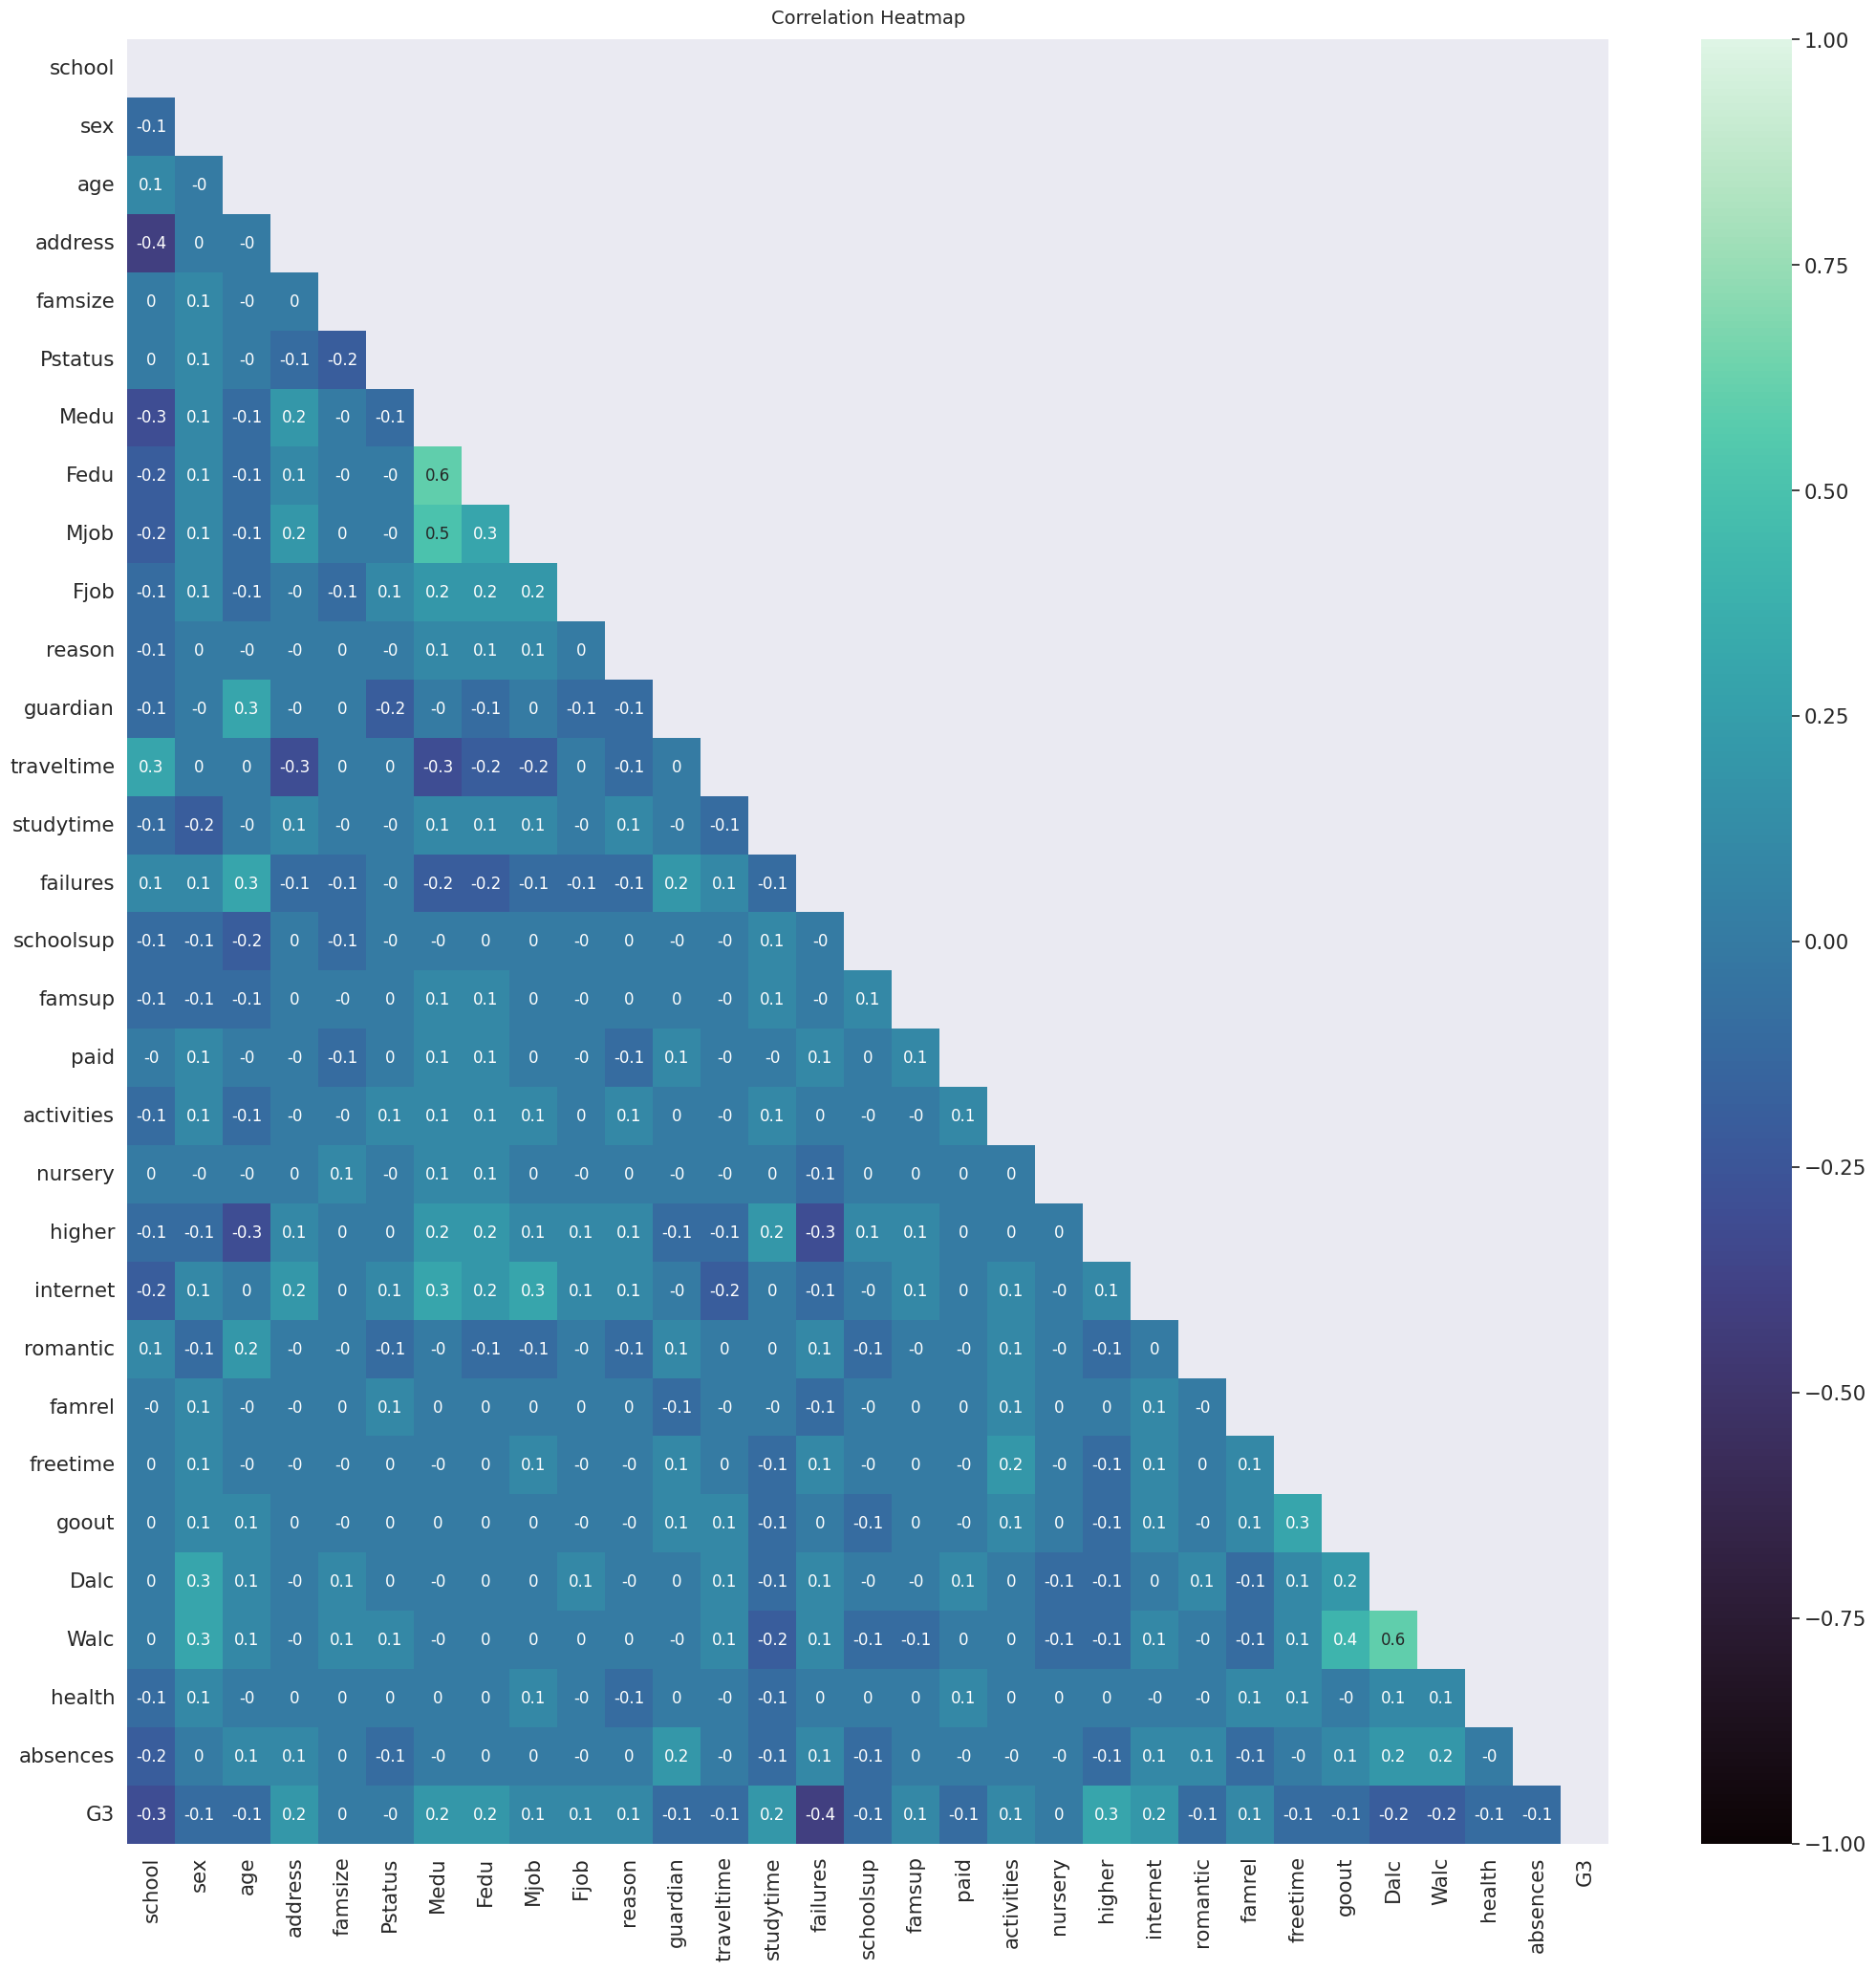

In [155]:
#https://medium.com/@szabo.bibor/how-to-create-a-seaborn-correlation-heatmap-in-python-834c0686b88e
import seaborn as sns

plt.figure(figsize=(25, 25))
sns.set(font_scale=1.4)
corr = data_processed.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
heatmap = sns.heatmap(corr.round(1), mask=mask, vmin=-1, vmax=1, annot = True, annot_kws={"size": 12}, cmap = "mako")
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':14}, pad=12);

It can be seen that data does not have a lot of correlation.

Most correlation is found in those cases:

* G3 correlates negatively with previous failures

* G3 negatively correlates with school

* Alcohol consumption on weekdays correlate with alcohol consumption on weekends

* Failures correlate with age

* Mother's education correlates with father's education, same for occupations

Also, we can look at target correlations separately

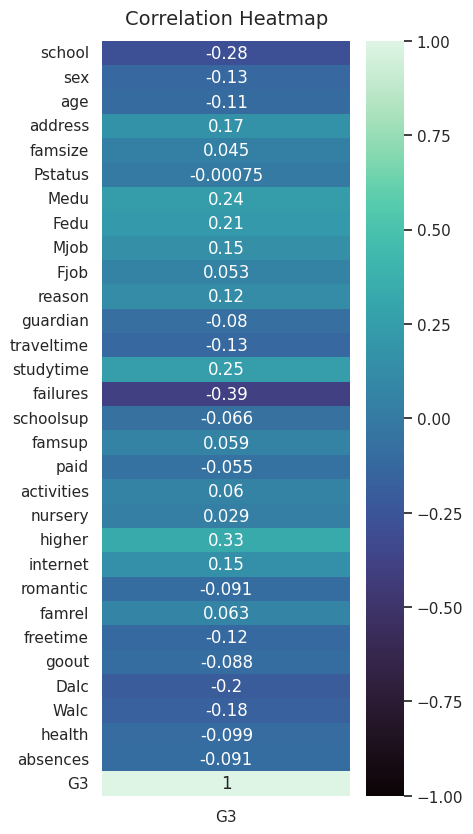

In [156]:
plt.figure(figsize=(4, 10))
sns.set(font_scale=1)
heatmap = sns.heatmap(corr[["G3"]], vmin=-1, vmax=1, annot = True, annot_kws={"size": 12}, cmap = "mako")
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':14}, pad=12);

We can derive that there is no high correlation with target. We can notice few facts:

* Positive correlation of G3 with time of study a week

* Positive correlation of G3 with desire to pursue higher education

* Negative correlation of previous failures with G3

* Negative correlation with school of education - MS school seems to be worse

## Additional graphic analysis

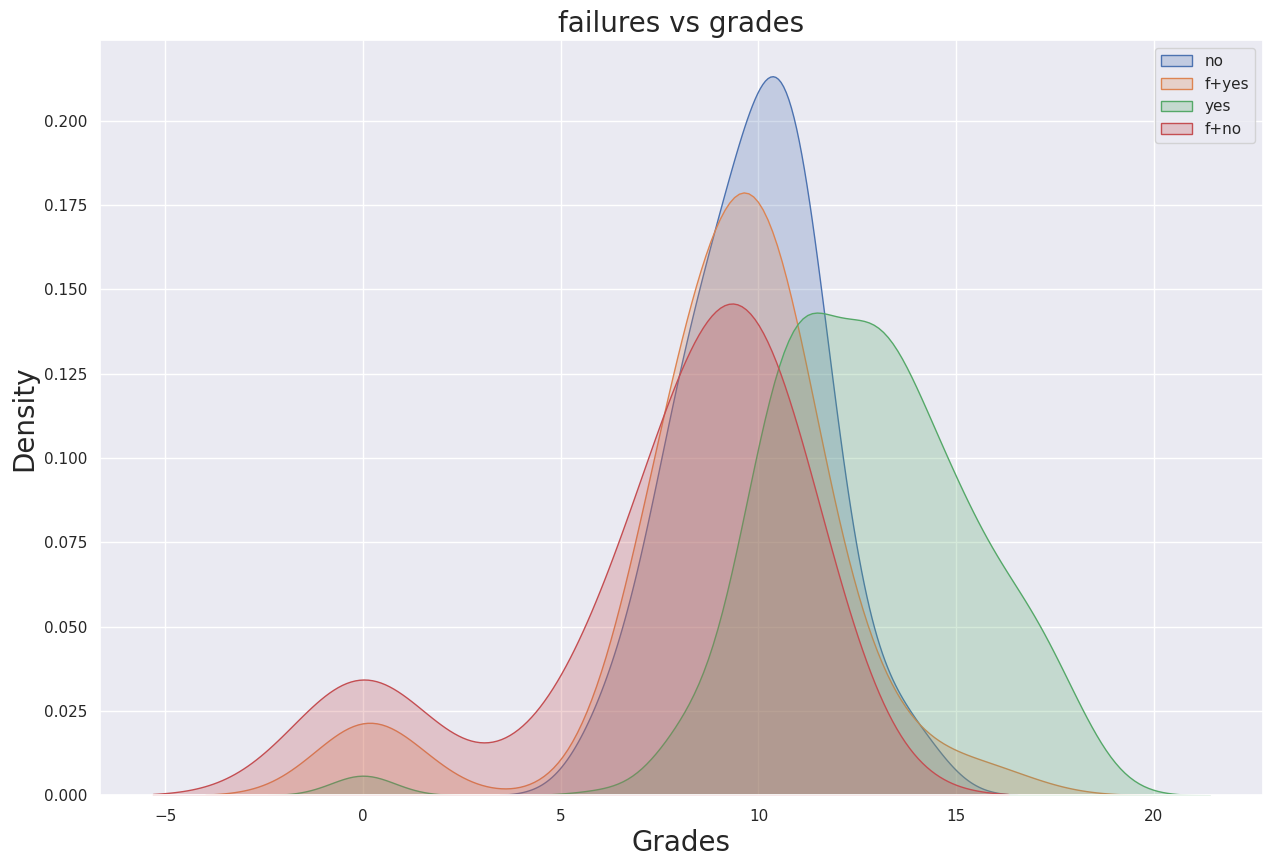

In [157]:
fig, ax = plt.subplots(figsize=(15,10))
sns.kdeplot(data.loc[(data['failures'] == 0)&(data['higher'] == 'no'), 'G3'], label='no', shade = True)
sns.kdeplot(data.loc[(data['failures'] != 0)&(data['higher'] == 'yes'), 'G3'], label='f+yes', shade = True)
sns.kdeplot(data.loc[(data['failures'] == 0)&(data['higher'] == 'yes'), 'G3'], label='yes', shade = True)
sns.kdeplot(data.loc[(data['failures'] != 0)&(data['higher'] == 'no'), 'G3'], label='f+no', shade = True)
ax.set_title('failures vs grades', fontsize = 20)
ax.set_xlabel('Grades', fontsize = 20);
ax.set_ylabel('Density', fontsize = 20)
ax.legend()

This picture represents probability distributions of 4 groups: "wants a higher education and has zero failures", "wants a higher education and has one or more failures", "doesn't want a higher education has zero failures" and "doesn't want a higher education and has one or more failures". This distinguishment is based on two features with highest correlation with target value (see the correlation matrix). Apparently, most of these groups are again very similar in terms of distributions. However, the group that wants a higher education and has zero failures has prominently higher marks. It can be assumed that these are necessary conditions for the highest marks.
We have also previously observed that boxplots show very little difference in marks based on given features. Which leads to believe that these features can be used to identify the most and the least successful students in regards to marks. As for the students that are not on the ends of distribution of marks, it might be problematic to determine the relationship of features and target value for them as this group is quite homogeneous.

# Models

## Outlier detection

We decided to use PCA for outlier detection. First we need to check the amount of variance explained in relation to amount of components. 

In [158]:
data_processed = pd.get_dummies(data)
data_processed

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,...,activities_no,activities_yes,nursery_no,nursery_yes,higher_no,higher_yes,internet_no,internet_yes,romantic_no,romantic_yes
0,18,4,4,2,2,0,4,3,4,1,...,1,0,0,1,0,1,1,0,1,0
1,17,1,1,1,2,0,5,3,3,1,...,1,0,1,0,0,1,0,1,1,0
2,15,1,1,1,2,0,4,3,2,2,...,1,0,0,1,0,1,0,1,1,0
3,15,4,2,1,3,0,3,2,2,1,...,0,1,0,1,0,1,0,1,0,1
4,16,3,3,1,2,0,4,3,2,1,...,1,0,0,1,0,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
644,19,2,3,1,3,1,5,4,2,1,...,0,1,1,0,0,1,0,1,1,0
645,18,3,1,1,2,0,4,3,4,1,...,1,0,0,1,0,1,0,1,1,0
646,18,1,1,2,2,0,1,1,1,1,...,0,1,0,1,0,1,1,0,1,0
647,17,3,1,2,1,0,2,4,5,3,...,1,0,1,0,0,1,0,1,1,0


In [159]:
X = data_processed.drop('G3', axis=1)
Y = data_processed.G3

from sklearn.preprocessing import StandardScaler
X_std=StandardScaler().fit_transform(X)

from sklearn.decomposition import PCA
pca_2 = PCA(n_components=30)
pca_result_2 = pca_2.fit_transform(X_std)

import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(y=pca_2.explained_variance_ratio_, mode='lines+markers', name = "% of Var"))
fig.add_trace(go.Scatter(y=np.cumsum(pca_2.explained_variance_ratio_), name = "Cumsum of Var"))
fig.update_layout(
    title = "Explained Variance",
    title_x = 0.5,
    xaxis_title = "Components",
    yaxis_title = "% of Var explained"
)

In [160]:
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
pca = PCA(n_components=18)
X = data_processed.drop(columns = "G3").to_numpy()
X_pca = pca.fit_transform(X)
iso = IsolationForest()
iso.fit(X_pca)
iso_prediction = iso.predict(X_pca)

In [161]:
print("% of outliers:", (iso_prediction == -1).sum() / len(iso_prediction) * 100)

% of outliers: 4.776579352850539


In [162]:
outlier_index = np.where(iso_prediction == -1)

In [163]:
outlier_index[0]

array([ 61,  66, 108, 138, 143, 149, 150, 160, 162, 170, 179, 237, 242,
       250, 262, 279, 369, 379, 413, 433, 434, 491, 500, 502, 523, 527,
       547, 576, 598, 610, 626])

In [164]:
data_processed = data_processed.drop(outlier_index[0])

In [165]:
data_processed

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,...,activities_no,activities_yes,nursery_no,nursery_yes,higher_no,higher_yes,internet_no,internet_yes,romantic_no,romantic_yes
0,18,4,4,2,2,0,4,3,4,1,...,1,0,0,1,0,1,1,0,1,0
1,17,1,1,1,2,0,5,3,3,1,...,1,0,1,0,0,1,0,1,1,0
2,15,1,1,1,2,0,4,3,2,2,...,1,0,0,1,0,1,0,1,1,0
3,15,4,2,1,3,0,3,2,2,1,...,0,1,0,1,0,1,0,1,0,1
4,16,3,3,1,2,0,4,3,2,1,...,1,0,0,1,0,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
644,19,2,3,1,3,1,5,4,2,1,...,0,1,1,0,0,1,0,1,1,0
645,18,3,1,1,2,0,4,3,4,1,...,1,0,0,1,0,1,0,1,1,0
646,18,1,1,2,2,0,1,1,1,1,...,0,1,0,1,0,1,1,0,1,0
647,17,3,1,2,1,0,2,4,5,3,...,1,0,1,0,0,1,0,1,1,0


## Broad model checks

In [166]:
!pip install pycaret[full]

Defaulting to user installation because normal site-packages is not writeable


In [167]:
data_processed.G3 = data_processed.G3.astype(float)

In [168]:
from pycaret.regression import *
exp_reg = setup(data = data_processed, target = "G3", fold_shuffle=True, preprocess = False, silent = True)
compare_models(exclude = ["xgboost", "lightgbm"])

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,1.9390,6.8455,2.5853,0.2839,0.3366,0.1707,0.1430
catboost,CatBoost Regressor,1.9531,7.2192,2.6643,0.2341,0.3475,0.1723,0.9890
gbr,Gradient Boosting Regressor,2.0265,7.2018,2.6667,0.2265,0.3424,0.1795,0.0340
lar,Least Angle Regression,2.0122,7.4528,2.6972,0.2221,0.3520,0.1765,0.0150
br,Bayesian Ridge,1.9901,7.4329,2.6958,0.2209,0.3527,0.1755,0.0070
huber,Huber Regressor,2.0360,7.5929,2.7222,0.2061,0.3546,0.1769,0.0180
ridge,Ridge Regression,2.0434,7.5532,2.7185,0.2048,0.3528,0.1803,0.0060
lr,Linear Regression,2.0484,7.5766,2.7230,0.2020,0.3531,0.1808,0.1280
ada,AdaBoost Regressor,2.0732,7.6580,2.7321,0.1978,0.3509,0.1873,0.0700
omp,Orthogonal Matching Pursuit,2.0599,7.7553,2.7578,0.1840,0.3559,0.1837,0.0080


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='squared_error',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                      oob_score=False, random_state=3715, verbose=0,
                      warm_start=False)

## Train-test split

In [169]:
from sklearn.model_selection import train_test_split
X, Y = data_processed.drop(columns = "G3"), data_processed.G3
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state = 150)

## Gradient Boosting

First let's check quality on untuned boosting. The most logical metric seems to be MAE, since it just the mean deviation of model estimation of students' marks from the true marks

In [170]:
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import GradientBoostingRegressor
boost_regr = GradientBoostingRegressor(loss = "absolute_error")
boost_regr.fit(X_train, Y_train)
Y_pred = boost_regr.predict(X_test)
print(mean_absolute_error(Y_pred, Y_test))

2.281520855660298


Check feature importance

In [171]:
feature_importance = boost_regr.feature_importances_
sort_index = np.argsort(feature_importance)[::-1][:10]
fig = px.bar(x = data_processed.columns[sort_index].to_numpy(), y = feature_importance[sort_index])
fig.update_traces(marker_color = "#9A99D6", opacity = 0.8)
fig.update_layout(
    title = "Top 10 GB feature importance",
    title_x = 0.5,
    xaxis_title = "",
    yaxis_title = "Feature Importance",
)

Now let's crossvalidate 

In [172]:
from sklearn.model_selection import GridSearchCV
grid_params = {
    "loss":['absolute_error'],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [3, 5, 10],
    "max_features": ["auto", "sqrt", "log2"],
    "subsample": [0.5, 0.75, 0.8, 0.9, 1],
}
estimator = GradientBoostingRegressor()
grid_search = GridSearchCV(estimator, grid_params, scoring = "neg_mean_absolute_error", n_jobs = -1)
grid_search.fit(X_train, Y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='squared_error',
                                                 max_depth=3, max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_iter_no_change=N...
                                                 subsample=1.0, tol=0.0001,
  

In [173]:
#https://stackoverflow.com/questions/41475539/using-best-params-from-gridsearchcv
print('The parameters combination that would give best accuracy is: ')
print(grid_search.best_params_)
print('The best MAE achieved after parameter tuning via grid search is: ', grid_search.best_score_)

The parameters combination that would give best accuracy is: 
{'learning_rate': 0.05, 'loss': 'absolute_error', 'max_depth': 5, 'max_features': 'log2', 'subsample': 0.75}
The best MAE achieved after parameter tuning via grid search is:  -1.7873394619464307


In [174]:
feature_importance = grid_search.best_estimator_.feature_importances_
sort_index = np.argsort(feature_importance)[::-1][:10]
fig = px.bar(x = data_processed.columns[sort_index].to_numpy(), y = feature_importance[sort_index])
fig.update_traces(marker_color = "#9A99D6", opacity = 0.8)
fig.update_layout(
    title = "GB feature importance",
    title_x = 0.5,
    xaxis_title = "",
    yaxis_title = "Feature Importance",
)

## Random forest regressor

In [175]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(criterion="absolute_error")
rf.fit(X_train, Y_train)
Y_pred = rf.predict(X_test)
print(mean_absolute_error(Y_pred, Y_test))

2.319935483870968


In [176]:
grid_params = {
    "n_estimators": [25, 50, 100, 150],
    "criterion":['absolute_error'],
    "max_features": ["auto", "sqrt", "log2"],
    "max_samples": [0.5, 0.75, 0.8, 0.9, 1],
    "max_depth": [2, 5, 10, 25, None]
}
grid_search = GridSearchCV(rf, grid_params, scoring = "neg_mean_absolute_error", n_jobs = -1)
grid_search.fit(X_train, Y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='absolute_error',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             n_jobs=-1,
             param_gri

In [177]:
print('The parameters combination that would give best accuracy is: ')
print(grid_search.best_params_)
print('The best MAE achieved after parameter tuning via grid search is: ', grid_search.best_score_)

The parameters combination that would give best accuracy is: 
{'criterion': 'absolute_error', 'max_depth': None, 'max_features': 'sqrt', 'max_samples': 0.9, 'n_estimators': 150}
The best MAE achieved after parameter tuning via grid search is:  -1.8004874551971326


In [178]:
feature_importance = grid_search.best_estimator_.feature_importances_
sort_index = np.argsort(feature_importance)[::-1][:10]
fig = px.bar(x = data_processed.columns[sort_index].to_numpy(), y = feature_importance[sort_index])
fig.update_traces(marker_color = "#9A99D6", opacity = 0.8)
fig.update_layout(
    title = "RF feature importance",
    title_x = 0.5,
    xaxis_title = "",
    yaxis_title = "Feature Importance",
)